In [ ]:
# click Run All Cells
# Note: the file paths in this notebook were written to be ran on Google Colab

In [ ]:
# citations of orignal:
# """
# WGAN-GP video: https://www.youtube.com/watch?v=pG0QZ7OddX4&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=5
# WGAN-GP paper: https://arxiv.org/abs/1704.00028
# WGAN-GP github: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/4.%20WGAN-GP
# """

## Library Setup

In [ ]:
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import imageio

!pip install tensorflow_docs
import tensorflow_docs.vis.embed as embed
import torchvision.transforms as tvtf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 1.6 MB/s eta 0:00:00


## Prepare Dataset of Images

In [ ]:
#Gather images
!git clone https://github.com/LyJacky/ImageGeneration.git

Cloning into 'ImageGeneration'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 383 (delta 29), reused 77 (delta 28), pack-reused 305
Receiving objects: 100% (383/383), 54.91 MiB | 24.63 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
# hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16
image_size = 64
num_of_channels = 3
lambda_gradient_penalty = 10

discriminator_learning_rate = 1e-4
discriminator_features = 64
discriminator_iterations = 5

latent_dim = 100
generator_features = 64
generator_learning_rate = 5e-5

cuda


### Remove folders that dont have images
datasets.ImageFolder() follows a specific folder structure that
doesn't allow for any folders like /.git/

```
data/
├── train/
|   ├── class_0/
|   |   ├── 001.jpg
|   |   ├── 002.jpg
|   └── class_1/
|       ├── 004.jpg
|       └── 005.jpg
└── test/
    ├── class_0/
    |   ├── 006.jpg
    |   └── 007.jpg
    └── class_1/
        ├── 008.jpg
        └── 009.jpg
```

In [ ]:
!rm -r /content/ImageGeneration/ImageGeneration/ # remove recursively the contents within this file location
!rm -r /content/ImageGeneration/.ipynb_checkpoints/
!rm -r /content/ImageGeneration/.git/

rm: cannot remove '/content/ImageGeneration/.ipynb_checkpoints/': No such file or directory


In [ ]:
# transforms will be used to resize, normalize, and turn the images into tensors

transforms = tvtf.Compose(
  [
    tvtf.Resize(image_size), # to 64
    tvtf.ToTensor(),
    tvtf.Normalize(
        [0.5 for _ in range(num_of_channels)], [0.5 for _ in range(num_of_channels)]
    ),
  ]
)


In [ ]:
monet_dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=transforms)
dataloader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)

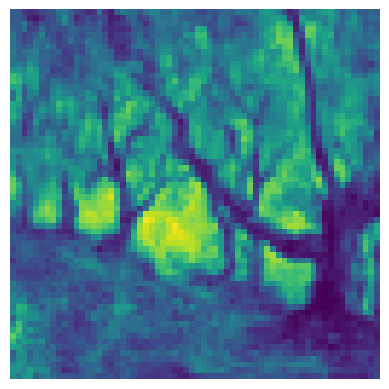

In [ ]:
# show a sample
plt.imshow((monet_dataset[1][0][2]))
plt.axis('off')
plt.show()

## Gradient Penalty
Gradient Penalty inputs: disciminator, real, fake

Combine/overlap fake and real into interpolated_images
>Example: 92.82% of real image  + 07.18% of fake image

Get mixed_scores from discriminator with interpolated images as the input

Get gradient of interpolated_images and mixed_scores

The penalty term is calculated as the squared difference from the norm of 1 for the gradients


In [ ]:
def gradient_penalty(discriminator, real, fake, device="cpu"):
  batch_size, C, H, W = real.shape
  epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # calcuate discriminator scores
  mixed_scores = discriminator(interpolated_images)

  gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_penalty = torch.mean((gradient - 1) ** 2)
  return gradient_penalty


## Discriminator

Discriminator Description:

Input layer takes in a tensor torch.Size([16, 3, 64, 64]) #Note: batch of 16, 3 channels, 64x64 image

First hidden layer expands the image to 128 nodes, and then 256 nodes, and finally 512 nodes.

The output layer produces a tensor that contains the probability of the image being real or fake.

<br>

Returns:
```torch.Size([16]) #Note: batch of 16```

Example of input: (noisy image)
```
fake.shape = torch.Size([16, 3, 64, 64])
fake = tensor([[[[ 1.0938e-03,  5.3604e-04, -2.0098e-06,  ...,  2.4565e-03,
          1.2322e-03,  2.0247e-04],
        [ 5.2938e-03, -3.9024e-03,  8.6430e-03,  ..., -2.3937e-03,
          4.5679e-03, -1.9812e-04],
        ...,
        [ 1.3473e-01,  1.3342e-01,  1.3703e-01,  ...,  1.3514e-01,
          1.3380e-01,  1.3328e-01],
        [ 1.3362e-01,  1.3695e-01,  1.3543e-01,  ...,  1.3721e-01,
          1.3583e-01,  1.3689e-01]]]], device='cuda:0',
      grad_fn=<TanhBackward0>)
```

Example of output:
```
len(discriminator_output) 16
discriminator_output.shape torch.Size([16])
discriminator_output = tensor([-176.8212, -176.8230, -176.8145, -176.8075, -176.7952, -176.8179,
        -176.8348, -176.8596, -176.8116, -176.8296, -176.8371, -176.8264,
        -176.8152, -176.8213, -176.8321, -176.8118], device='cuda:0',
      grad_fn=<ViewBackward0>)
```

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, num_of_channels, discriminator_features):
    super(Discriminator, self).__init__()
    self.discriminator = nn.Sequential(

      # Input Layer
      nn.Conv2d(num_of_channels, discriminator_features, kernel_size = 4, stride = 2, padding = 1),
      nn.LeakyReLU(0.2),

      # Second Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features, discriminator_features * 2, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 2, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Third Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features * 2, discriminator_features * 4, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 4, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Fourth Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features * 4, discriminator_features * 8, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 8, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Output Layer is 4x4 (Conv2d turns into 1x1)
      nn.Conv2d(discriminator_features * 8, 1, kernel_size=4, stride=2, padding=0)
    )


  def forward(self, x):
    return self.discriminator(x)

## Generator
Generator Description:

Takes in a noisy image of dimension 100, expands it to 1028 nodes

The next hidden layer is 512, followed by 256, and finally 128 where the output
layer returns a fake colored image of dimension 3x64x64.

<br>

Returns:
```torch.Size([16, 3, 64, 64]) #Note: batch of 16, 3 channels, 64x64 image```

Example of input:
```
(noisy image)
noise.shape = torch.Size([16, 100, 1, 1])
noise = tensor([[[[ 1.0680]],
        [[-0.6157]],
        [[ 0.4986]],
        ...,
        [[ 0.5693]],
        [[-2.0391]],
        [[-0.5566]]]], device='cuda:0')
```
Example of output:
```
fake.shape = torch.Size([16, 3, 64, 64])
fake = tensor([[[[ 1.0938e-03,  5.3604e-04, -2.0098e-06,  ...,  2.4565e-03,
          1.2322e-03,  2.0247e-04],
        [ 5.2938e-03, -3.9024e-03,  8.6430e-03,  ..., -2.3937e-03,
          4.5679e-03, -1.9812e-04],
        ...,
        [ 1.3473e-01,  1.3342e-01,  1.3703e-01,  ...,  1.3514e-01,
          1.3380e-01,  1.3328e-01],
        [ 1.3362e-01,  1.3695e-01,  1.3543e-01,  ...,  1.3721e-01,
          1.3583e-01,  1.3689e-01]]]], device='cuda:0',
      grad_fn=<TanhBackward0>)
```

In [ ]:
class Generator(nn.Module):

  def __init__(self, latent_dim, num_of_channels, generator_features):
    super(Generator, self).__init__()
    self.generator = nn.Sequential(

      #  Input Layer
      nn.Sequential(
        nn.ConvTranspose2d(latent_dim, generator_features * 16, kernel_size=4, stride=1, padding=0, bias=False,),
        nn.BatchNorm2d(generator_features * 16),
        nn.ReLU(),
      ),

      #  Second Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 16, generator_features * 8, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 8),
        nn.ReLU(),
      ),

      #  Third Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 8, generator_features * 4, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 4),
        nn.ReLU(),
      ),

      #  Fourth Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 4, generator_features * 2, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 2),
        nn.ReLU(),
      ),

      #  Output Layer
      nn.ConvTranspose2d(generator_features * 2, num_of_channels, kernel_size=4, stride=2, padding=1),
      nn.Tanh(),
  )

  def forward(self, x):
    return self.generator(x)

## Set up WGAN-GP
- Init weights
- Init generator, discriminator, weights, optimizers
- Generator architecture
- Discriminator architecture
- Init Epochs
- Create outputs directory to save fake images
- Create seed reproduce the same image over time with generator improvements


In [ ]:
def initialize_weights(model):
  for m in model.modules():
      if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
          nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
generator = Generator(latent_dim, num_of_channels, generator_features).to(device)
discriminator = Discriminator(num_of_channels, discriminator_features).to(device)

initialize_weights(generator)
initialize_weights(discriminator)

opt_generator = optim.Adam(generator.parameters(), lr=generator_learning_rate, betas=(0.0, 0.9))
opt_discriminator = optim.Adam(discriminator.parameters(), lr=discriminator_learning_rate, betas=(0.0, 0.9))

step = 0

In [ ]:
"""
Generator architecture
"""

generator.train()

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(12

In [ ]:
"""
Discriminator architecture
"""

discriminator.train()

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [ ]:
EPOCHS = 20

In [ ]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!mkdir /content/outputs
!mkdir /content/outputs/first_wgan # create directory to save generated outputs

In [ ]:
noise_dim = 100
num_examples_to_generate = 5

# We will reuse this seed overtime to visualize progress in the animated GIF
seed = torch.randn(num_examples_to_generate, noise_dim, 1, 1).to(device)

## Training Overview

> Note: The starting color of fake images change (dark blue, green, yellow, etc.)

For every epoch, we iterate through each batch in the dataset,

We take random noise and pass it to the generator to create a fake image
We train the discriminator on both real and fake images,

We train the discriminator 5 times with gradient penalty
> Note: This ensures that the discriminator’s gradients do not change too rapidly or too slowly.

And we train the generator using the discriminator’s predictions 1 time.

Depending on the batch index and the epoch, we display some of the fake images with different random input noise and we generate the same fake images using the same seed to watch the generator improve over time.


EPOCH [0/20] Batch 0/19 Loss D: -26.2527, loss G: 29.2976


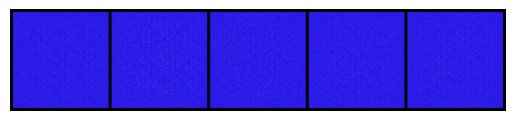

EPOCH [5/20] Batch 0/19 Loss D: -563.0641, loss G: 281.1770


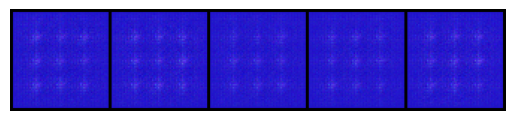

EPOCH [10/20] Batch 0/19 Loss D: -1082.7463, loss G: 541.7865


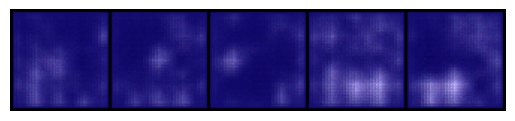

EPOCH [15/20] Batch 0/19 Loss D: -1682.2166, loss G: 839.6570


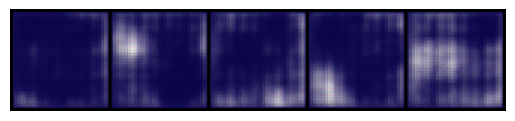

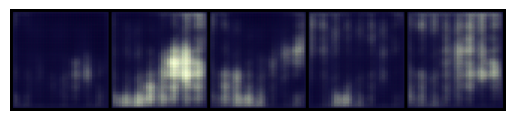

In [ ]:
#training


for epoch in range(EPOCHS):
  for batch_idx, (real_img, _) in enumerate(dataloader):
    real = real_img.to(device)
    if len(real) < batch_size: # sometimes tensor is less
        break

    for _ in range(discriminator_iterations):
      noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
      fake = generator(noise)

      disc_real = discriminator(real).reshape(-1)
      disc_fake = discriminator(fake).reshape(-1)

      gradient_pen = gradient_penalty(discriminator, real, fake, device=device)
      loss_discriminator = (
          -(torch.mean(disc_real) - torch.mean(disc_fake)) + lambda_gradient_penalty*gradient_pen
      )
      discriminator.zero_grad()
      loss_discriminator.backward(retain_graph=True)
      opt_discriminator.step()

    output = discriminator(fake).reshape(-1)
    loss_generator = -torch.mean(output)
    generator.zero_grad()
    loss_generator.backward()
    opt_generator.step()

    #generate pics with random noise
    with torch.no_grad():
        img_grid_fake = torchvision.utils.make_grid(
          fake[:5], normalize=True
        )
        plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        if epoch % 5 == 0 and batch_idx == 0:
          print(
              f"EPOCH [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_discriminator:.4f}, loss G: {loss_generator:.4f}"
          )
          plt.show()

    # generate with consistent seed and save GIF
    with torch.no_grad():
        if epoch % 2 == 0 and batch_idx == 0:
          fake = generator(seed)
          img_grid_fake = torchvision.utils.make_grid(
            fake[:5], normalize=True
          )
          plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
          plt.axis('off')
          plt.savefig('/content/outputs/first_wgan/image_at_epoch_{:04d}.png'.format(epoch + 1))

    step += 1

## Create GIF

In [ ]:
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/outputs/first_wgan/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-22-2def134f9928>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



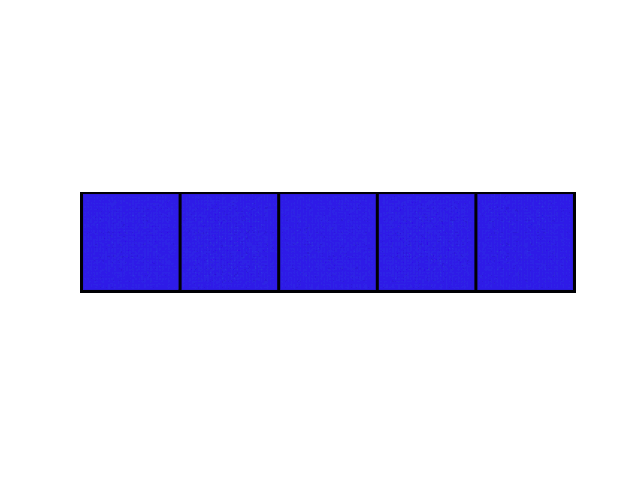

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)